
# Project: Investigate a Dataset - No-show appointments dataset

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

The focus of this investigation is missed appointments. This No-show dataset from Kaggle provides the details of 100k medical appointments in Brazil. Specifically, the data holds information about the hospital where patients scheduled appointments, demographic and health data of the patients, and whether or not they kept their appointments.

My analyses are focussed on the dependent variables: appointment_ID or patient ID, in order to predict which type of patient shows up at their hospital appointments.

In my analysis of appointment data, I look at the differene in attendance for same-day appointments versus other appointments. For these other appointments, I compare the difference between kept and missed appointments by length of time between scheduling and appointment. I consider appointment attendance by the day of the week of the appointment. I also check the location of the appointment for correlation to patient attendance.

For patient information, I checked to see the mean age of patients by attendance at appointments. For this, I divided patients into two groups, attenders and missers (by percentage of appointment attended).

, and patient demographic features like  hospital and age group, and by patient health factors. 



Can I predict what type of person is most likely to keep an appointment?

Here are the column names and a brief description of each:

- PatientId: A unique ID for each patient</li>
- AppointmentID: A unique ID for each appointment</li>
- ScheduledDay: The day the patient made their appointment</li>
- AppointmentDay: The day of the appointment</li>
- Gender, Age: patient demographic information</li>
- Neighbourhood: The location of the hospital</li>
- Scholarship:  ‘Yes’ denotes that the patient is using Brasilian government assistance (Bolsa Família)</li>
- Hipertension, Diabetes, Alcoholism, Handcap: health factors. Presumably ‘Handcap’ refers to disability status</li>
- SMS_received: Whether the patient received a text reminder.</li>
- No-show: Whether the patient missed an appointment (Yes) or kept an appointment (No)</li>

In [1]:
# import statements

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import dask.dataframe as dd
import seaborn as sb
pd.options.mode.chained_assignment = None  # Apparently this helps me with all my renaming issues

# 'magic word'
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

The No-show data comes from Kaggle and is provided by Udacity. Here are the first few rows of data, and the total number of rows and columns.

In [2]:
# data from Kaggle and Udacity: noshowappointments-kagglev2-may-2016.csv

# df = pd.read_csv('/Database_No_show_appointments/noshowappointments-kagglev2-may-2016.csv')
# df.head()
# error: dataset too large

# use dask
df_dd = dd.read_csv("Database_No_show_appointments/noshowappointments-kagglev2-may-2016.csv", assume_missing=True)
df_dd.head(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903.0,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62.0,JARDIM DA PENHA,0.0,1.0,0.0,0.0,0.0,0.0,No
1,5.589978e+14,5642503.0,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56.0,JARDIM DA PENHA,0.0,0.0,0.0,0.0,0.0,0.0,No
2,4.262962e+12,5642549.0,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62.0,MATA DA PRAIA,0.0,0.0,0.0,0.0,0.0,0.0,No
3,8.679512e+11,5642828.0,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8.0,PONTAL DE CAMBURI,0.0,0.0,0.0,0.0,0.0,0.0,No
4,8.841186e+12,5642494.0,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56.0,JARDIM DA PENHA,0.0,1.0,1.0,0.0,0.0,0.0,No


In [3]:
# change the dataframe type to continue using pandas
df = df_dd.compute()

The dataset was too large to import with pandas, so I imported it with dask and then converted it to a pandas dataframe. Above is the first five rows from the dataset.

Here is a overview of the data:

In [4]:
# quick overview of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null float64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null float64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null float64
Hipertension      110527 non-null float64
Diabetes          110527 non-null float64
Alcoholism        110527 non-null float64
Handcap           110527 non-null float64
SMS_received      110527 non-null float64
No-show           110527 non-null object
dtypes: float64(9), object(5)
memory usage: 11.8+ MB


Currently the dataset has 110527 rows and 14 columns.

In [5]:
# look for duplicated rows
d = sum(df.duplicated())
print('There are', d, 'duplicated rows.')

There are 0 duplicated rows.


I searched for duplicated rows, but there were none.

In [6]:
# look for duplicates where none should be
s = sum(df['AppointmentID'].duplicated())
print('Appointment IDs are duplicated', s, 'times.')

Appointment IDs are duplicated 0 times.


I also searched for duplicated appointment IDs. There should only be one record per appointment. There were no duplicates.

Some column names and datatypes need to be changed.

First, ScheduledDay and AppointmentDay are 'object' datatypes. I changed these to date.

In [7]:
# change day columns to datetime type
df[['ScheduledDay', 'AppointmentDay']] = df[['ScheduledDay', 'AppointmentDay']].apply(pd.to_datetime)
df['Scheduled_Date'] = df['ScheduledDay'].dt.date
df['Appointment_Date'] = df['AppointmentDay'].dt.date

# drop any appointments that were scheduled after the appointment date
df = df.loc[df['Scheduled_Date'] <= df['Appointment_Date']]

Also, I removed appointments that were scheduled after they occurred.

In [8]:
# get the difference in time between scheduling and the appointment date
df['Time_Difference'] = (df.Appointment_Date - df.Scheduled_Date).astype('timedelta64[D]')

#get rid of NaN
df['Time_Difference'] = df['Time_Difference'].replace('NaN', 0)

I created a column called 'Time_Difference' that represents the delay between scheduling an appointment and the appointment date. I changed null values in this column to zero.

In [9]:
# make attendance make sense
df['No-show'] = df['No-show'].replace(['No'],'hold')

# if no-show is yes, they didn't show up and the value should be attendance = 0
df['No-show'] = df['No-show'].replace(['Yes'],'0')

# if no-show is no, they did show up and the value should be attendance = 1
df['No-show'] = df['No-show'].replace(['hold'],'1')

df['No-show'].value_counts()

1    88208
0    22314
Name: No-show, dtype: int64

There are 88208 appointments attended, and 22314 appointments missed. 

I changed the No-show column and values to be less confusing. In the original data, a 'no' in the 'No-show' column indicates a kept appointment and a 'Yes' indicates a missed appointment. A 'yes' in a row about appointments indicating that the appointment was kept is clearer.

In [10]:
# change column headings
df = df.rename(columns = {'AppointmentID': 'Appointment_ID',
                          'PatientId': 'Patient_ID',
                          'AppointmentDay': 'Appointment_Day',
                          'ScheduledDay': 'Scheduled_Day',
                          'Scholarship': 'Assistance',
                          'Neighbourhood': 'Hospital',
                          'Hipertension': 'Hypertension',
                          'Handcap': 'Disability',
                          'No-show': 'Attendance'})

The different capitalisation between PatientId and AppointmentID is confusing. Hypertension is spelled as 'hipertension'.  I changed these three column headers to 'Patient_ID', 'Appointment_ID' and 'Hypertension'. 

As column headers, 'Disability' is preferrable to 'Handcap' and 'Assistance' is clearer than 'Scholarship'. 'Neighbourhood' refers to the location of the hospital, so that has been changed to 'Hospital'. Also, underscores were added where a space would naturally go to make the headers easier to read.

In [11]:
# make a value counter/printer because will use it more than once
def getvaluecounts(df, column_1, column_2):
    x = column_1
    y = column_2
    count = df.groupby([x, y]).count()
    return(count)

df_appointments = df

# change values to not scientific numbers, also + 1 (I don't want a zero)
for column in ['Appointment_ID','Hospital','Patient_ID', 'Attendance']:
         df_appointments[column] = df_appointments.groupby(column).ngroup() + 1

x = df_appointments.shape
print(x)

(110522, 17)


I made a function for getting value counts easily. Currently the dataset has 110,522 rows and 17 columns.
 
I changed the values for Patient_ID and Appointment_ID as they were too long for easy reading: patient IDs are needlessly in scientific notation. The patient ids need to be unique, but their actual value is probably irrelevant. As they were randomly assigned, I changed them to integers.

Some patients have multiple appointments. It would make more sense to add up each patient's appointments by attendance. That way, each patient is represented once. If we need information about individual appointments, we can use the df_appointments dataframe for analysis. 

What if a patient had a summer birthday?

In [12]:
# make a df and name it throw-away so i don't use it later by accident
df_throw_away = df

# i only need age and patient ID for this
df_throw_away = pd.DataFrame(df, columns = ['Age','Patient_ID'])

# both columns are changed to numbers(thanks ngroup)
for column in ['Age','Patient_ID']:
         df_throw_away[column] = df_throw_away.groupby(column).ngroup()
        
'''
i assume first birthday value is kept 
when patient id duplicates are dropped
but it's only a one-year difference
so i'm not going to worry about it
'''
# how to groupby and get nunique: thank you grepper
df_birthday_people = df_throw_away.groupby('Patient_ID')['Age'].nunique().to_frame(name = 'count').reset_index() 

# tried to write a function to do this for me but i failed to make this:
#
#      df_disability = df.groupby('Patient_ID')['disability'].nunique().to_frame(name = 'count').reset_index() 
#      print(df_disability.groupby('count').count())
#
# be run by this:
#      df_disability = pd.DataFrame(df,columns=['Patient_ID','Disability'])
#      changestatus(df_disability, df['Patient_ID'], df['Disability'])

#      def changestatus(df_1, column_1, column_2): # get the count of unique values from a column and print out
#            df_1 = df.groupby(column_1)[column_2].nunique().to_frame(name = 'count').reset_index() 
#            df_1.groupby('count')
#            print(df_1.groupby('count').count()) # <== keeps returning errors no matter what i do

# how to get number of occurences in a column: marsja.se
print(df_birthday_people.groupby('count').count())

       Patient_ID
count            
1           61131
2            1168


Some patients have 2 ages, birthdays happen.

1168 patients had birthdays during the time period of data collection. This is interesting, but the relevance for this analysis is that I can use this code to see if any patients changed status on other factors such as alcoholism, diabetes, hypertension, assistance, gender, or hospital (they didn't).

I can make a separate dataframe representing patients as individuals in my analysis section. The df_appointments dataframe represents individual appointments, not individual patients.

In [13]:
df_freq = df_appointments

# make a frequency column
df_freq['Frequency'] = df_appointments.groupby('Patient_ID')['Patient_ID'].transform('count')

# make sure attendance is a number
df_freq["Attendance"] = df_freq["Attendance"].astype(str).astype(int)

# get number of appointments per patient
df_freq['Attendance_Sum'] = df_freq.groupby('Patient_ID')['Attendance'].transform('sum')

# get an ratio of total appointments kept divided by total appointments made
df_freq['Attendance_Ratio'] = df_freq['Attendance_Sum']/df_freq['Frequency']
        
# make sure there are no 'inf' values, why aren't they just zero?
df_freq = df_freq.drop_duplicates(subset=['Patient_ID'])

df_patients = df_freq

Now I have two dataframes to work from: a df_appointments to look at each appointment individually and a df_patients to look at each patient individually.

I look for outliers for the patients' ages.

Text(0,0.5,'Number of Patients')

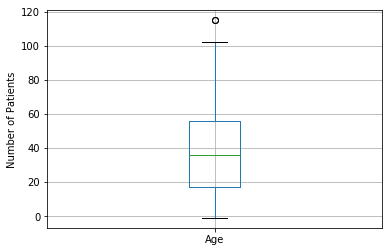

In [14]:
# look for outliers on box plot.
# df_appointments.boxplot('Age')
df_patients.boxplot('Age').set_ylabel('Number of Patients')

Here is a boxplot. The y-axis is the range of patient ages, showing an outlier for patient ages. I will remove it.

Text(0,0.5,'Number of Patients')

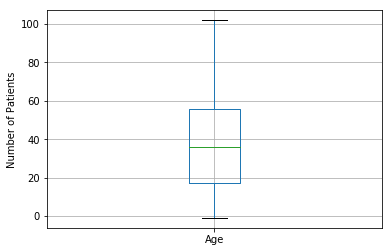

In [15]:
# get the mean and the standard deviation using numpy
df_patients_mean, df_patients_std = np.mean(df_patients), np.std(df_patients)

# identify ages beyond the standard deviation
outside_the_box = df_patients_std * 3
lowest, highest = df_patients_mean - outside_the_box, df_patients_mean + outside_the_box
# make a df that only has ages in the box
df_patients.drop(df_patients[df_patients['Age'] > highest['Age']].index, inplace = True)
df_patients.drop(df_patients[df_patients['Age'] < lowest['Age']].index, inplace = True)
df_patients.boxplot('Age').set_ylabel('Number of Patients')

I removed the patient outliers by age. Here is a boxplot representing the age column. The y-axis is the range of patient ages.

The data is cleaned. Here are the first five rows:

In [16]:
# take a peek
df_appointments.head(5)

,Patient_ID,Appointment_ID,Gender,Scheduled_Day,Appointment_Day,Age,Hospital,Assistance,Hypertension,Diabetes,Alcoholism,Disability,SMS_received,Attendance,Scheduled_Date,Appointment_Date,Time_Difference,Frequency,Attendance_Sum,Attendance_Ratio
0,30846,29333,F,2016-04-29 18:38:08,2016-04-29,62.0,40,0.0,1.0,0.0,0.0,0.0,0.0,2,2016-04-29,2016-04-29,0.0,2,4,2.0
1,55326,29080,M,2016-04-29 16:08:27,2016-04-29,56.0,40,0.0,0.0,0.0,0.0,0.0,0.0,2,2016-04-29,2016-04-29,0.0,2,4,2.0
2,15723,29116,F,2016-04-29 16:19:04,2016-04-29,62.0,46,0.0,0.0,0.0,0.0,0.0,0.0,2,2016-04-29,2016-04-29,0.0,2,4,2.0
3,9019,29300,F,2016-04-29 17:29:31,2016-04-29,8.0,55,0.0,0.0,0.0,0.0,0.0,0.0,2,2016-04-29,2016-04-29,0.0,2,3,1.5
4,23942,29074,F,2016-04-29 16:07:23,2016-04-29,56.0,40,0.0,1.0,1.0,0.0,0.0,0.0,2,2016-04-29,2016-04-29,0.0,1,2,2.0


<a id='eda'></a>
## Exploratory Data Analysis
The first part of this investigation is an analysis of the appointments.

First, I compare attendance for same-day appointments versus other appointments. Then, for appointments with a more than one day delay between scheduling and appointment date, I examine how the length of the delay affects attendance. Also, I compare appointment attendance at different hospitals.

The following part of my investigation is an analysis of patient factors.

For patient information, I checked to see the mean age of patients by attendance at appointments. For this, I divided patients into two groups, attenders and missers (by percentage of appointment attended).

I compared these two groups by patient demographic features like government assistance and hospital location, and health factors.

Can I predict what type of person is most likely to keep an appointment?

[[I also compare the hospitals where the appointments are missed to those where appointments are kept. ]]

I also compare the hospitals on the age, assistance, and disablity level of their patients.

### Which appointments are being missed? Appointment Questions Analysis

I wondered if same day appointments were missed at a different rate, because presumably these were urgent appointments. 

Text(0,0.5,'Number of Appointments')

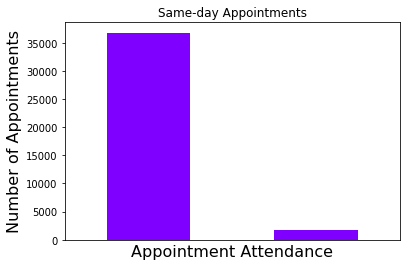

In [17]:
# get a df of appointments made on the same day they were scheduled
df_same_day_appointment = pd.DataFrame(df_appointments,columns=['Attendance','Time_Difference', 'Scheduled_Date', 'Appointment_Date'])
df_same_day_appointment = df_same_day_appointment.loc[df_same_day_appointment['Scheduled_Date'] == df_same_day_appointment['Appointment_Date']] 

# get a df of appointments made on a different day than they were scheduled
df_not_same_day_appointment = pd.DataFrame(df_appointments,columns=['Attendance','Time_Difference', 'Scheduled_Date', 'Appointment_Date'])
df_not_same_day_appointment = df_not_same_day_appointment.loc[df_not_same_day_appointment['Scheduled_Date'] != df_not_same_day_appointment['Appointment_Date']]

# show the bar chart
df_same_day_appointment['Attendance'].value_counts().plot(kind='bar', title = 'Same-day Appointments', cmap = 'rainbow')
plt.tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
plt.xlabel('Appointment Attendance', fontsize = 16)
plt.ylabel('Number of Appointments', fontsize = 16)

Absolutely, same-day appointments have an excellent attendance rate. Anyone might have a reason for an urgent appointment and it is unlikely they would skip it. The most likely patient to keep an appointment will have a same-day appointment. This is common sense.

To determine the effect of a longer delay between scheduling an appointment and the appointment date, I look at the correlation between attendance and delay between scheduling and appointment keeping for the appointments that are not same-day appointments.

In [18]:
def getcorr(df, column_1, column_2): # get the correlation of 2 values from a df and print them out
    x = column_1
    y = column_2
    corr = x.corr(y)
   # corr2 = corr.round(2)
    corr2 = round(corr,1)
    print('The correlation is', corr2)

In [19]:
# make a dataframe to hold not same day appointments
df_nsd = pd.DataFrame(df_not_same_day_appointment, columns=['Attendance','Time_Difference'])

# drop same day apps
df_nsd = df_nsd.loc[df_nsd['Time_Difference'] > 0]

# get the correlation between attendance and delay
getcorr(df_nsd, df_nsd['Attendance'], df_nsd['Time_Difference'])

df_nsd = pd.DataFrame(df_nsd,columns=['Attendance','Time_Difference'])
y = df_nsd.groupby('Attendance').mean()
print('\n',y)

The correlation is -0.1

             Time_Difference
Attendance                 
1                 17.218254
2                 15.013142


At a glance, there does not seem to be very much difference in attendance by delay between scheduling and appointment date. The correlation is low and the time delay is 17 days for missed appointments and 15 days for attended appointments.

Next I look for outliers, not including same-day appointments.

Text(0,0.5,'Number of Appointments')

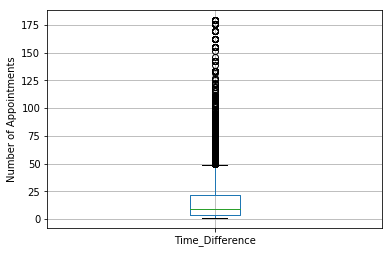

In [20]:
# get attendance and time difference of all the appointments
df_nsd.boxplot('Time_Difference').set_ylabel('Number of Appointments')

I then remove outliers in delay length and make a new boxplot to show the results.

Text(0,0.5,'Number of Appointments')

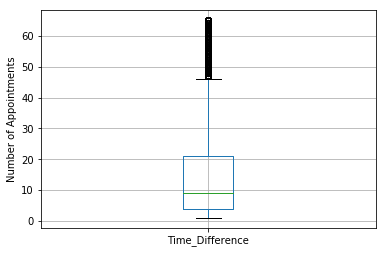

In [21]:
# get the mean and the standard deviation using numpy
df_delay_std, df_delay_std = np.mean(df_nsd), np.std(df_nsd)

# identify ages beyond the standard deviation
outside = df_delay_std * 3
lowest, highest = df_delay_std - outside, df_delay_std + outside

# make a df without outliers
df_nsd.drop(df_nsd[df_nsd['Time_Difference'] > highest['Time_Difference']].index, inplace = True)
df_nsd.drop(df_nsd[df_nsd['Time_Difference'] < lowest['Time_Difference']].index, inplace = True)
df_nsd.boxplot('Time_Difference').set_ylabel('Number of Appointments')

,Time_Difference
Attendance,
1,15.901029
2,13.719940


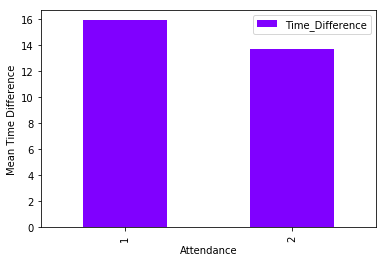

In [22]:
# show attendance by delay 
df_at = pd.DataFrame(df_nsd,columns=['Attendance','Time_Difference'])

# find the mean time difference in days between attended vs missed
# when outliers are removed
df_at.groupby('Attendance').describe(include = 'all')

# graph showing mean of time difference for attendance
df_at.groupby(['Attendance'])[['Time_Difference']].mean().plot(kind = 'bar', cmap = 'rainbow').set_ylabel('Mean Time Difference')
df_at.groupby(['Attendance'])[['Time_Difference']].mean()

Once outliers are removed, the disparity in attendance by length of time between scheduling and keeping an appointment is still small.

In [23]:
print(getcorr(df_at, df_at['Attendance'], df_at['Time_Difference']))

The correlation is -0.1
None


The correlation between attendance and time difference remains low.

It appears that, in general, if the time between scheduling and appointment date was any longer than 13 days, the appointments were more often missed.

The same day appointments are heavily attended.

The day of the week of the appointment affected whether or not someone attended their appointment. The correlation between day of the week and attendance is:

In [24]:
df_days = df_appointments.reset_index()
df_days['Day_of_Week'] = df_appointments['Appointment_Day'].dt.dayofweek
df_d = pd.DataFrame(df_days,columns=['Day_of_Week','Attendance'])

#df_d['Attendance'] = pd.to_numeric(df_days['Attendance'])

getcorr(df_days, df_days['Day_of_Week'], df_days['Attendance'])

The correlation is 0.0


In [25]:
df_d.groupby('Day_of_Week').describe(include = 'all')

Attendance                                             
                 count      mean       std  min  25%  50%  75%  max
Day_of_Week                                                        
0.0            22714.0  1.791494  0.406249  1.0  2.0  2.0  2.0  2.0
1.0            25633.0  1.798346  0.401243  1.0  2.0  2.0  2.0  2.0
2.0            25866.0  1.801709  0.398720  1.0  2.0  2.0  2.0  2.0
3.0            17246.0  1.808419  0.393556  1.0  2.0  2.0  2.0  2.0
4.0            19019.0  1.791367  0.406343  1.0  2.0  2.0  2.0  2.0
5.0               39.0  1.794872  0.409074  1.0  2.0  2.0  2.0  2.0

The correlation between the day of the week that the appointment falls on and whether or not a patient kept that appointment is weak. Thursday appointments were marginally better attended than others, but the correlation is very poor.

Attendance at appointments is not correlated to the location of the hospital.

In [26]:
getcorr(df_appointments, df_appointments['Attendance_Ratio'], df_appointments['Hospital'])

The correlation is 0.0


There are about 80 hospitals. Some do get more appointments than others, which can be seen below. The best attended will have the highest hospital attendance ratio, while having at least an average frequency of attended appointments. 

To discover the hospital with the highest attendance ratio, I added a column for a sum of each hospital's frequency of appearance, a column of kept appointments sum per hospital, and hospital appointment attendance ratio, the ratio for each hospital of attended to missed appointments.

Text(0,0.5,'Number of Attended Appointments')

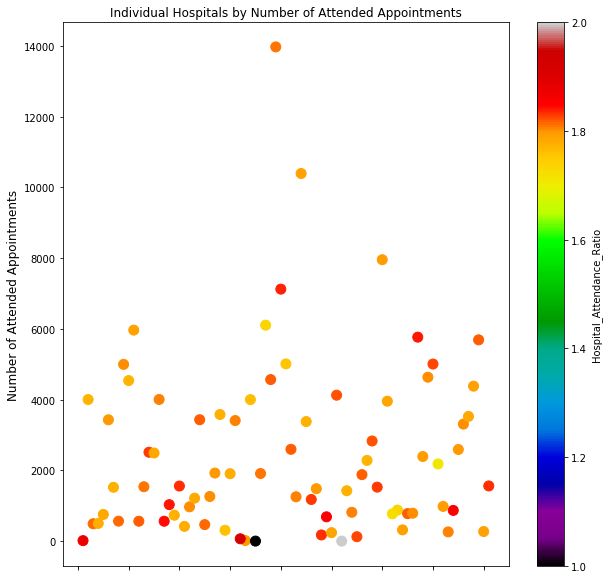

In [27]:
# get most attended hospitals
df_hospital_freq = pd.DataFrame(df_appointments,columns=['Hospital', 'Attendance'])

# make a frequency column
df_hospital_freq['Hospital_Frequency'] = df_appointments.groupby('Hospital')['Hospital'].transform('count')

# make sure attendance is a number
df_hospital_freq["Attendance"] = df_hospital_freq["Attendance"].astype(str).astype(int)

# get number of appointments per patient
df_hospital_freq['Hospital_Attendance_Sum'] = df_hospital_freq.groupby('Hospital')['Attendance'].transform('sum')

# get an ratio of total appointments kept divided by total appointments made
df_hospital_freq['Hospital_Attendance_Ratio'] = df_hospital_freq['Hospital_Attendance_Sum']/df_hospital_freq['Hospital_Frequency']
        
# make sure there are no 'inf' values, why aren't they just zero?
df_hospital_freq = df_hospital_freq.drop_duplicates(subset=['Hospital'])
df_hospital_freq.plot(figsize=(10,10),kind = 'scatter', x = 'Hospital', y = 'Hospital_Attendance_Sum', c = 'Hospital_Attendance_Ratio', cmap = 'nipy_spectral', s = 100, title = 'Individual Hospitals by Number of Attended Appointments', colorbar = 'True')
plt.ylabel('Number of Attended Appointments', fontsize = 12)

Each dot above represents one of the 81 hospitals included in the dataset. The colour of the dots corresponds to the appointment attendance ratio for that hospital. The y-axis is the number of attended appointments. This is the best visual representation I could come up with that showed all 81 hospitals, their attendance ratios, and the number of attended appointments they had.

The hospital with the most appointments is Hospital \#39, with 6252 appointments. Out of the 81 hospitals, however, it is not the hospital with the best attendance ratio. It looks like there's a hospital numbered in the 40s with an attendance ratio above 1.8 and about 7000 attended appointments. Can I find it?

In [28]:
df_hospital_freq.head(3)

,Hospital,Attendance,Hospital_Frequency,Hospital_Attendance_Sum,Hospital_Attendance_Ratio
0,40,2,3877,7123,1.837245
2,46,2,644,1178,1.829193
3,55,2,69,126,1.826087


Hospital \#40 has an attendance ratio of ~1.84 and 7123 kept appointments: it is best attended hospital.

The appointment factors are whether or not the appointment was for the same day it was scheduled, and the length of time between being scheduled and being kept, but not really the day of the week the appointment was for. The location of the appointment did not correlate to attendance levels.

There is a clear winner of 'Best Attended Hospital' and that is Hospital \#40.

### Whose appointments are being missed? Demographic questions analysis

Certain demographic groups might be more likely to miss appointments.

The mean age of those who keep or miss appointments seems about the same.

In [29]:
df_aa = pd.DataFrame(df,columns=['Attendance','Age'])

df_aa.groupby('Attendance').describe(include = 'all')

Age                                                    
              count       mean        std  min   25%   50%   75%    max
Attendance                                                             
1           22314.0  34.317872  21.965009  0.0  16.0  33.0  51.0  115.0
2           88208.0  37.790064  23.338878 -1.0  18.0  38.0  56.0  115.0

These means, age 34 for attenders and age 37 for missers, are skewed by the number of babies in the data. At a glance, the babies are clearly both numerous and dependable. 

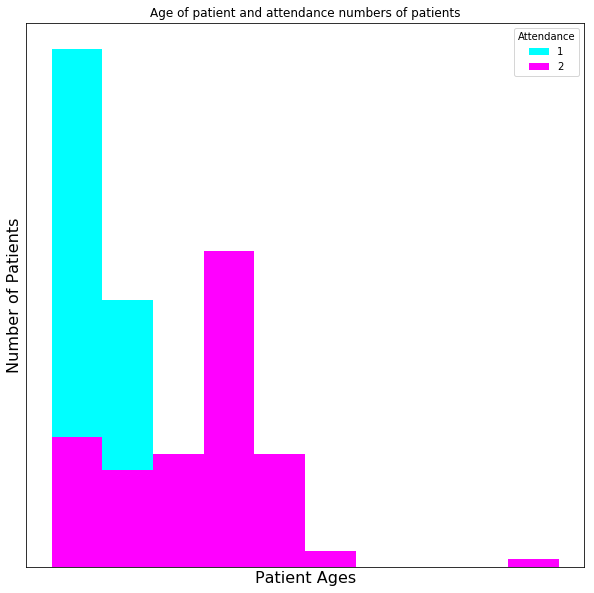

In [30]:
df_sample_a = df.sample(n=9000)
aa = pd.crosstab(df_sample_a.Age, df_sample_a.Attendance).plot(kind='hist', cmap = 'cool', figsize = (10,10))
aa.legend(title='Attendance')
plt.tick_params(left = False, right = False, labelleft = False, labelbottom = False, bottom = False)
plt.title('Age of patient and attendance numbers of patients')
plt.ylabel('Number of Patients', fontsize = 16)
plt.xlabel('Patient Ages', fontsize = 16)
plt.show()

So many babies are keeping their appointments. 

Look at appointment ratios correlated to attenders vs missers. These are individual patients: they are either attenders (attended more than 75% of their appointments), or missers (missed more than 25% of their appointments).

In [31]:
# use a sample this is taking ages
df_sample_p = df_patients.sample(n=9000)
df_keepers = df_sample_p.loc[df_sample_p['Attendance_Ratio'] > 0.75]
df_missers = df_sample_p.loc[df_sample_p['Attendance_Ratio'] < 0.25]
df_keepers['Attendance_Ratio'] = df_keepers['Attendance_Ratio'].astype('int')
df_missers['Attendance_Ratio'] = df_missers['Attendance_Ratio'].astype('int')
x = getcorr(df_keepers, df_keepers['Attendance_Ratio'],df_keepers['Age'])
y = getcorr(df_missers, df_missers['Attendance_Ratio'],df_missers['Age'])

The correlation is 0.1
The correlation is nan


The correlations are weak or non-existant, but missers are younger on average than attenders.

The correlation is -0.0


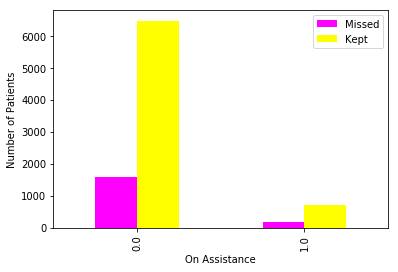

In [32]:
getcorr(df, df['Assistance'], df['Attendance'])

df_sample_a = df.sample(n=9000)
aa = pd.crosstab(df_sample_a.Assistance, df_sample_a.Attendance).plot(kind='bar', cmap = 'spring', legend = True)
plt.ylabel('Number of Patients')
plt.xlabel('On Assistance')
plt.legend(["Missed", "Kept"]);

Athough there is no correlation between assistance and attendance, it appears that people who are not on assistance are more likely to keep an appointment.

There are much fewer patients on assistance that otherwise.

Is there a correlation between assistance and attendance ratio?

In [33]:
getcorr(df, df['Assistance'], df['Attendance_Ratio'])

df_aaaa = pd.DataFrame(df_appointments,columns=['Attendance_Ratio','Assistance', 'Age'])

The correlation is -0.0


There is no correlation between patients on assistance and their percentage of appointments attended.

In general, babies, perhaps by sheer numbers, are excellent attenders. Otherwise, attenders seem to skew a little older than missers. Perhaps because they only had 2 appointments, Hospital \#35 has great attendance.

### Do sick people keep their appointments? Health questions analysis

Health factors may correlate with missed appointments. For example, men with alcoholism might miss more appointments than women with diabetes.

Take a look at the patients with a high attendance ratio.

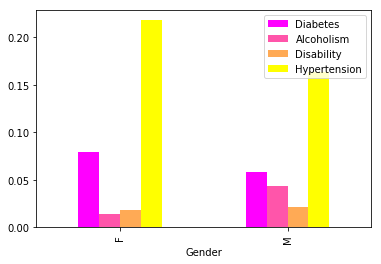

In [34]:
df_keepers = df_sample_p.loc[df['Attendance_Ratio'] > 0.75]

df_k = pd.DataFrame(df_keepers,columns=["Diabetes", "Alcoholism", "Disability", "Gender", "Hypertension"])
df_k.groupby('Gender').mean().plot(kind = 'bar', cmap = 'spring')
# 1 = f,0 = m

Of the attenders, it appears people with hypertension are most represented.
Correlations are in general, weak.

In [35]:
# maybe i should have make the data numerical instead of categorical
# i have to change it to do the chart
from sklearn.preprocessing import LabelEncoder

df_sm = pd.DataFrame(df_freq, columns = ['Age', 'Gender', 'Time_Difference', 'Hospital', 'Hypertension', 'Diabetes', 'Alcoholism', 'Disability', 'Attendance_Ratio'])

# had to reset the index for this to work, but i'm not sure why
df_sm = df_sm.reset_index()

# this is going to make my categorical values into numbers
labelencoder=LabelEncoder()
for column in df_sm.columns:
    df_sm[column] = labelencoder.fit_transform(df_sm[column])

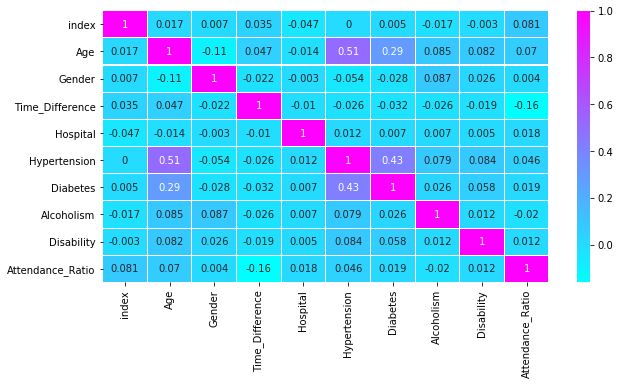

In [36]:
# I need to be able to see it all at once on my screen so i squished it
plt.figure(figsize = (10,5))
sb.heatmap(df_sm.corr().round(3),linewidths=.1,cmap="cool", annot = True)

I didn't see any strong correlations with attendance, but it is interesting to note that health factors have a greater correlation with attendance than length of scheduling delay.

Does disability influence attendance of people on assistance?

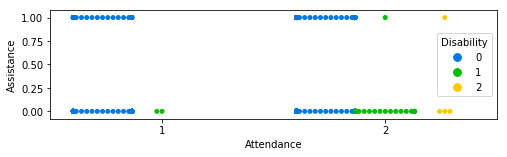

In [37]:
df_sample = df_patients.sample(n=2000)
df_sample = df_sample[['Attendance', 'Assistance', 'Age', 'Disability']]
df_sample['Disability'] = df_sample['Disability'].astype('int64')

plt.figure(figsize=(8,2))
sb.swarmplot(x = 'Attendance', y = 'Assistance', data = df_sample, hue = 'Disability', dodge = True, palette = 'nipy_spectral')
# thank you stackoverflow for how to remove y axis ticks
plt.tick_params(axis='y', which='both', bottom = False, top = False, labelbottom = False)

People with disabilities not on assistance were more likely to make appointments than their assisted peers. The correlations are low, however.

<a id='conclusions'></a>
## Conclusions
The most likely patient to keep an appointment will have a same-day appointment. This is common sense. The patients at hospital 35 had the highest attendance ratios.

But who were the best attenders?

In [38]:
# get the patients with perfect attendance ratios
df_keepers.describe()
sort_by_highest_ratio_p = df_keepers.loc[df['Attendance_Ratio'] == 2]

# get the mean for each factor
sort_by_highest_ratio_p.mean()

Patient_ID          31069.309344
Appointment_ID      54020.505792
Age                    38.086332
Hospital               42.820849
Assistance              0.093282
Hypertension            0.212046
Diabetes                0.077375
Alcoholism              0.021467
Disability              0.020541
SMS_received            0.289730
Attendance              2.000000
Time_Difference         9.913977
Frequency               1.516293
Attendance_Sum          3.032587
Attendance_Ratio        2.000000
dtype: float64

The most likely patient to attend an appointment is aged 38, who scheduled about 10 days in advance and doesn't go to the hospital more than once a month or so. He might have hypertension, but probably not. He's not on assistance and he probably received an SMS.

### Limitations
I made a good guess as to what 'Disability' indicated, but it was only a guess. I didn't check to see which were more likely to be missed, first or subsequent appointments. All the correlations seemed fairly weak, except for obvious ones like diabetes with hypertension.

I was unable to write a function that would show if any patients changed status on other factors such as alcoholism, diabetes, hypertension, assistance, gender, or hospital over more than one visit to the hospital.

I focussed on the attenders, not the missers: there may have been a very clear type of misser but I wouldn't know. I didn't figure out what the SMS might indicate. A reminder call? A follow-up call? I didn't investigate.

Football season ends in early May. This time period is included in the data: I wondered if there was a difference in attendance by gender in the first two weeks of May, but I didn't end up comparing by gender for that time period. I also did a cursory check for important events or holidays in Brazil at the time of data collection, but nothing stood out so I abandoned that avenue of inquiry.

## OPTIONAL: Question for the reviewer
 
If you have any question about the starter code or your own implementation, please add it in the cell below. 

For example, if you want to know why a piece of code is written the way it is, or its function, or alternative ways of implementing the same functionality, or if you want to get feedback on a specific part of your code or get feedback on things you tried but did not work.

Please keep your questions succinct and clear to help the reviewer answer them satisfactorily. 

> **_Your question_**
I was unable to write a function to check if any of the patients had a change in the different health factors across multiple appointments. What could I have done differently?

> Why can't I just get the most attended hospital with this and appending .max() or .head()?
> df_ah['Hospital'].value_counts()

In [40]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0